# Machine Learning- COIY065H7

## Coursework, WAME Optimiser Evaluation

Copy of this has been loaded to https://github.com/bfromson/ML-WAME-Coursework. It works with runtime GPU in Colab but requires file locations for loading CSV files to be altered and cannot write the result files when running on Colab. If cloning and running locally then the Landsat csv files should be in same directory as the code and the parameter files for controlling runs should be in a directory called "DataForRuns" in the same location.

Load modules for use throughout the workbook

In [1]:
indir = './DataForRuns/'
infile = 'AdamOnly'

In [2]:
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.nn import CrossEntropyLoss
from torch.nn import Module
from torch.optim import *
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset

from torchvision.transforms import ToTensor
from torchsummary import summary

import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics

from matplotlib import pyplot as plt
%matplotlib inline

from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

import time

import csv

Verify versions of ML libraries being used

In [3]:
import sys
print("Python version:        ", sys.version.replace("\n","\t"))
print("PyTorch version:       ", torch.__version__)
print("CUDA Version:          ", torch.version.cuda)
print("Scikit-learn Version:  ", sklearn.__version__)

Python version:         3.7.3 (default, Mar 27 2019, 22:11:17) 	[GCC 7.3.0]
PyTorch version:        1.5.0
CUDA Version:           10.2
Scikit-learn Version:   0.22.1


## Routines to be used 

PrintResults will output a table of Precision and Recall for each class

In [4]:
def PrintResults(predictions, actuals, printit):
    ynp = predictions.numpy()
    testnp = actuals.numpy()
    if printit:
        print("Class \t Cases \t TP \t FP \t Precision \t Recall \t F1")
    allcases = 0
    allTP = 0
    allFP = 0
    output=[]
    epsilon = 1e-10
    F1avg = 0
    Pavg = 0
    Ravg = 0
    for i in range(0,6):
        cases = sum(testnp==i)
        allcases += cases
        TP = sum((ynp==i) & (testnp==i))
        FP = sum((ynp==i) & (testnp!=i))
        allTP += TP
        allFP += FP
        Precision = TP / (TP + FP + epsilon)
        Recall = TP / cases
        F1 = 2 * (Precision * Recall) / (Precision + Recall + epsilon)
        Pavg += Precision
        Ravg += Recall
        F1avg += F1
        if printit:
            print(i, "\t", cases, "\t" ,TP, "\t", FP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3), "\t", "\t", round(F1, 3))
        output.append(i)
        output.append(cases)
        output.append(TP)
        output.append(FP)
    Precision = Pavg / 6
    Recall = Ravg / 6
    F1 = F1avg / 6
    output.append(Precision)
    output.append(Recall)
    output.append(F1)
    if printit:
        print("Total", "\t", allcases, "\t" ,allTP, "\t", allFP, "\t", round(Precision, 3), "\t", "\t", round(Recall, 3), "\t", "\t", round(F1,3))
    return(output)

Check returns the class predictions and accuracy score of a model

In [5]:
def Check(Xvals, Yactuals, model):
    predictraw = model(Xvals.to(device)).detach().cpu()
    predict = np.argmax(predictraw, axis=-1)
    predict_score = predict == Yactuals
    correct = np.sum(predict_score.numpy(), axis=-1)
    sumtot = predict_score.shape[0]
    score = correct / sumtot
    return (predict, score)

## Wame optimizer

Logic for the optimiser follows the paper by Mosca, 

A. Mosca and G. D. Magoulas, ‘Training convolutional networks with weight-wise adaptive learning rates’, in ESANN, 2017.

The code for the PyTorch optimizer implementation was adapted from the PyTorch souce code using -

PyTorch optimizer class code: https://pytorch.org/docs/stable/optim.html

Example of RProp implementation: https://pytorch.org/docs/stable/_modules/torch/optim/rprop.html

And guidance on writing a custom optimizer for AdamW: http://mcneela.github.io/machine_learning/2019/09/03/Writing-Your-Own-Optimizers-In-Pytorch.html


In [6]:
class wame(Optimizer):


    def __init__(self, params,lr=1e-3, alpha=0.9, etas=(0.1, 1.2), zetas=(0.01, 100), epsilon=1e-10, debug=False ):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= alpha:
            raise ValueError("Invalid learning rate: {}".format(alpha))
        if not 0.0 < etas[0] < 1.0 < etas[1]:
            raise ValueError("Invalid eta values: {}, {}".format(etas[0], etas[1]))

        defaults = dict(alpha=alpha, etas=etas, zetas=zetas, lr=lr, epsilon=epsilon, debug=debug)
        super(wame, self).__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure=None):
        loss = None
        if closure is not None:
            loss = closure()
   
        for group in self.param_groups:    
            etaminus, etaplus = group['etas']
            zeta_min, zeta_max = group['zetas']
            alpha = group['alpha']
            lr = group['lr']
            epsilon = group['epsilon']
            debug = group['debug']
            _p = 0

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('wame does not support sparse gradients')
                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    state['prev'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['prev'] = grad
                    state['Theta'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['Z'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    state['zeta'] = torch.ones_like(p.data, memory_format=torch.preserve_format)
                    state['gradmult'] = torch.zeros_like(p.data, memory_format=torch.preserve_format)
                    
                    state['step_size'] = grad.new().resize_as_(grad).fill_(group['lr']) ### check on initialisation
                    state['prev'] = grad
                    
                if (_p == 0) & debug:
                    print("Weights at start: ",p.data.sum(), p.data.size())
                step_size = state['step_size']
                Theta = state['Theta']
                Z = state['Z']
                zeta = state['zeta']
                gradmult = state['gradmult']                    
                
                state['step'] += 1

                gradmult = grad.mul(state['prev'])
                zeta[gradmult.gt(0.)] = zeta[gradmult.gt(0.)].mul(etaplus).clamp(zeta_min, zeta_max)
                zeta[gradmult.lt(0.)] = zeta[gradmult.lt(0.)].mul(etaminus).clamp(zeta_min, zeta_max)
                zeta[gradmult.eq(0.)] = 1
                
                Z = Z.mul(alpha).add(zeta.mul(1 - alpha))
                Theta = Theta.mul(alpha).add(grad.mul(grad).mul(1 - alpha))

                step_size = Z.mul(-lr).mul(grad).div(Theta.add(epsilon))

                grad = grad.clone(memory_format=torch.preserve_format)
                
                # update parameters
                p.data = p.data.add(step_size)
                
                if (_p == 0) & debug:
                    print("Step number ", state['step'])
                    print("Weights after update: ",p.data.sum(), p.data.size())
                    print("Updates applied: ",step_size.sum(), step_size.size())
                    print("Theta: ",Theta.sum())
                    print("Z: ",Z.sum())
                    print("zeta: ",zeta.sum())
                    print("grad: ",grad.sum())
                    print("grad_sqd", grad_sqd.sum())
                    print("gradmult", gradmult.sum())
                state['prev'] = grad
                
                _p = _p + 1

        return loss


# Load Data

The Landsat data recommended in the coursework description has been used for this project. The two files of training and testing data have been merged into a single file with headers added. The features have been labelled as "F1-F36" and the class labelled as "Class". An additional column named "TrainTest" has been added containing the value "Train" or "Test" to indicate the origin of that row of data. 

## Load all data from single file

Split into train and test datasets. 

From each dataset extract the features to an X variable and the classes to a Y variable.

As the classes are numeric rather than categorical change their values to be sequential from 0 to 5 to simplify the model building

In [7]:
alldata = pd.read_csv("sat.all.csv")
traindata = alldata[alldata['TrainTest'] == 'train']
testdata = alldata[alldata['TrainTest'] == 'test']


In [8]:
trainX = traindata.iloc[:,0:36].to_numpy()
trainY= traindata.iloc[:,36].to_numpy()

testX = testdata.iloc[:,0:36].to_numpy()
testY = testdata.iloc[:,36].to_numpy()

for i in range(1,8):
    trainY[trainY==i] = i-1
    testY[testY==i] = i-1

trainY[trainY==6] = 5
testY[testY==6] = 5

### Data Normalization

This routine will be called to normalize data within each fold as the model is built

In [9]:
def normalizeData(trainX, valX):
    scaler = StandardScaler()
    scalerFunc = scaler.fit(trainX)

    trainX_norm = scalerFunc.transform(trainX)
    valX_norm = scalerFunc.transform(valX)
    
    return(trainX_norm, valX_norm)

# PyTorch Model Specification

This is a parameter driven model where the number of units in the first hidden layer and the number of layers to be used can be specified when a model is instantiated.

The ratio of units between consecutive hidden layers has been fixed at 2:1, though this could be altered. 

An alternative approach would be to allow an array of unit counts to be passed as parameters to the model where each value would represent the number of units in a layer and the number of layers would be the no of items in the array. Thsi approach was not used as it would complicate the automation of the model runs.

In [10]:
in_features = 36
out_classes = 6

class TestModel(Module):
    def __init__(self, num_units=in_features*2, hidden_layers=4 ):
        
        self.hidden_layers = hidden_layers
        hidden = []
        hidden.append(num_units)
        for i in range(1,hidden_layers):
            hidden.append(max(out_classes*2,int(num_units/2**i)))
        
        super(TestModel, self).__init__()
        self.fc1 = nn.Linear(in_features, hidden[0])

        if hidden_layers > 1:
            self.relu1 = nn.ReLU()
            self.fc2 = nn.Linear(hidden[0], hidden[1])
        if hidden_layers > 2:
            self.relu2 = nn.ReLU()
            self.fc3 = nn.Linear(hidden[1], hidden[2])
        if hidden_layers > 3:
            self.relu3 = nn.ReLU()
            self.fc4 = nn.Linear(hidden[2], hidden[3])
        if hidden_layers > 4:
            self.relu4 = nn.ReLU()
            self.fc5 = nn.Linear(hidden[3], hidden[4])
        if hidden_layers > 5:
            self.relu5 = nn.ReLU()
            self.fc6 = nn.Linear(hidden[4], hidden[5])
        
        self.reluLast = nn.ReLU()
        self.fcLast = nn.Linear(hidden[hidden_layers-1], out_classes)

    def forward(self, x):
        
        hidden_layers = self.hidden_layers
        
        y = self.fc1(x)

        if hidden_layers > 1:
            y = self.relu1(y)
            y = self.fc2(y)
        if hidden_layers > 2:
            y = self.relu2(y)
            y = self.fc3(y)
        if hidden_layers > 3:
            y = self.relu3(y)
            y = self.fc4(y)
        if hidden_layers > 4:
            y = self.relu4(y)
            y = self.fc5(y)
        if hidden_layers > 5:
            y = self.relu5(y)
            y = self.fc6(y)

        y = self.reluLast(y)
        y = self.fcLast(y)
        
        return y

## RunModel

Executes a single model run with inputs of the model to run and training and validation datasets

In [11]:
def RunModel(model, opt, epochs, batch_size, trainX, trainY, valX, valY):
    accuracies = []
    validations = []
    errors = []

    train_score = 0
    epoch = 0

    trainXY_tensor = TensorDataset(trainX, trainY)
    train_loader = DataLoader(trainXY_tensor, batch_size=batch_size)
        
    while (epoch < epochs):
        batch = 0
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)
            opt.zero_grad()
            predict_y = model(train_x)
            error = loss(predict_y, train_label.long())
            error.backward()
            opt.step()

            batch = batch + 1
    

        train_pred, train_score = Check(trainX, trainY, model)
        error = loss(model(trainX), trainY.to(device).long())
        val_pred, val_score = Check(valX, valY, model)

        accuracies.append(train_score)
        validations.append(val_score)
        errors.append(error)
    
        epoch += 1   
        
    return(accuracies, errors, validations)

## RunFolds

Runs the model using the supplied feature and class datasets with the data split into the number of folds requested. The final parameter is a boolean which if instructs the routine to print progress information on each fold.

In [12]:
def RunFolds(model, opt, epochs, nfolds, batch_size, trainX, trainY, outputrequired):
    
    fold = 0
    torch.save(model.state_dict(),'initial_weights.state')

    foldAcc = []
    foldVal =  []
    foldErr = []
    allResults = []

    for trainIndex, testIndex in nfolds.split(trainX, trainY):
        
        foldTrainX = trainX[trainIndex]
        foldValX = trainX[testIndex]
        
        foldTrainY = trainY[trainIndex]
        foldValY = trainY[testIndex]
        
        if outputrequired:
            classcount = []
            for i in range(0,6):
                classcount.append(sum(foldTrainY==i))
            print("Before processing, item count and distribution")
            print("Fold ",fold + 1," before processing, item count and distribution ",sum(classcount),classcount,    
                  " X range: ",foldTrainX.min(),foldTrainX.max())

        model.load_state_dict(torch.load('initial_weights.state'))
    
        foldTrainX, foldValX = normalizeData(foldTrainX, foldValX)

        #oversampler = RandomOverSampler(sampling_strategy='minority')
        #oversampler = RandomOverSampler()
        #foldTrainX, foldTrainY = oversampler.fit_resample(foldTrainX, foldTrainY)
        #foldTrainX, foldTrainY = oversampler.fit_resample(foldTrainX, foldTrainY)
        #foldTrainX, foldTrainY = oversampler.fit_resample(foldTrainX, foldTrainY)
        
        if outputrequired:
            classcount = []
            for i in range(0,6):
                classcount.append(sum(foldTrainY==i))
            print("Fold ",fold + 1,"  after processing, item count and distribution ",sum(classcount),classcount,    
                  " X range: {:.3f} {:.3f}".format(foldTrainX.min(),foldTrainX.max()))
            

        trainX_tensor = torch.from_numpy(foldTrainX).float()
        trainY_tensor = torch.from_numpy(foldTrainY).float()

        valX_tensor = torch.from_numpy(foldValX).float()
        valY_tensor = torch.from_numpy(foldValY).float()

        time00 = time.perf_counter()
        torch.manual_seed(7)

        acc, val, err = RunModel(model, opt, epochs, batch_size, trainX_tensor, trainY_tensor, valX_tensor, valY_tensor)
    
        time01 = time.perf_counter()
        train_pred, train_score = Check(trainX_tensor, trainY_tensor, model)
        error = loss(model(trainX_tensor), trainY_tensor.to(device).long()).detach().cpu().numpy()
        val_pred, val_score = Check(valX_tensor, valY_tensor, model)
        if outputrequired:
            print('fold: {} \t accuracy: {:.6f} error: {:.6f} validation accuracy: {:.6f} time {:.3f}s'.format(
               fold + 1, train_score, error, val_score, time01 - time00))
        allResults.extend(PrintResults(val_pred, valY_tensor, outputrequired))

        foldAcc.append(train_score)
        foldVal.append(val_score)
        foldErr.append(error)
    
        fold += 1

    return(foldAcc, foldVal, foldErr, allResults)

# Read the parameter file

Parameters stored in a CSV file are read and the model generator will be run for each set of parameters.

Update the string infile to change the input file

In [13]:
allruns = pd.read_csv(indir + infile + ".csv",sep=",")

print(allruns.T[0].to_list())

[300, 2, 2048, 0.001, 200, 10, 'Adam', 0.85]


# This is block to execute runs

## One run for each line in parameter file:

##### read parameters from each line of file, and display parameters being used
##### instantiate a model according to parameters (use GPU if available)
##### set up optimizer and fold generator according to parameters
##### Call RunFolds to execute all the folds
##### accumulate all results so they can be saved to file

In [14]:
count = 0

allresults = []

for index,row in allruns.iterrows():
    num_units = int(row['num_units'])
    hidden_layers = int(row['hidden_layers'])
    batch_size = int(row['batch_size'])
    lr = row['lr']
    epochs = int(row['epochs'])
    fold_splits = int(row['fold_splits'])
    optName = row['optName']
    alpha = row['alpha']
    
    blurb = False
    
    print("Executing run number", count)
    print('Optimiser {} Using {} hidden_layers with {} units in first layer. Batch size of {} for {} epochs. \
{} folds. Learning rate {:.1e} Alpha {:.2f}'.format(
            optName, hidden_layers, num_units, batch_size, epochs, fold_splits, lr, alpha))
    print()

    if torch.cuda.is_available():
        model = torch.nn.DataParallel(TestModel(num_units=num_units, hidden_layers=hidden_layers)).cuda()
        device = torch.device("cuda")
    else:
        model = TestModel()
        device = torch.device("cpu")

    if blurb:
        print(model)

    if optName == "Wame":
        opt = wame(model.parameters(), lr=lr, alpha=alpha)
    if optName == "SGD":
        opt = SGD(model.parameters(), lr=lr)
    if optName == "Adam":
        opt = Adam(model.parameters(), lr=lr)

    loss = CrossEntropyLoss().to(device)

    nfolds = StratifiedKFold(n_splits=fold_splits, shuffle=True)
    
    starttime = time.perf_counter()
    foldAcc, foldVal, foldErr, tables = RunFolds(model, opt, epochs, nfolds, batch_size, trainX, trainY, blurb)
    runtime= time.perf_counter() - starttime
    
    print('Results Accuracy: mean {:.3f} std {:.3f} Validation Accuracy: mean {:.3f} std {:.3f} \
Runtime {:.2f} seconds'.format(
        np.mean(foldAcc), np.std(foldAcc), np.mean(foldVal), np.std(foldVal), runtime) )
    print()
    print()      
    
    allresults.append(allruns.T[count].to_list() + foldAcc + foldVal + [runtime] + tables )
          
    count += 1
    
print(" Al runs run")

Executing run number 0
Optimiser Adam Using 2 hidden_layers with 300 units in first layer. Batch size of 2048 for 200 epochs. 10 folds. Learning rate 1.0e-03 Alpha 0.85

Results Accuracy: mean 0.947 std 0.004 Validation Accuracy: mean 0.907 std 0.009 Runtime 58.32 seconds


 Al runs run


# Store 

### all results into a separate CSV file

In [93]:
import csv
with open(indir + "Z" + infile + 'Results.csv', 'w+') as file:
    writer = csv.writer(file)
    writer.writerows( allresults )

# EXECUTE TO HERE WHEN RUNNING EXPERIMENTS

## Only run final Test when a model has been selected

# TEST on true test dataset

When a suitable candidate model has been built test it on the test dataset

This should only be run when all candidate model parameters have been assessed using the kFold runs specified. Frequent use of the test data will corrupt the parameter selection and leak information from the test data into the final model 

In [15]:
model.load_state_dict(torch.load('initial_weights.state'))

normTrainX, normTestX = normalizeData(trainX, testX)

trainX_tensor = torch.from_numpy(normTrainX).float()
trainY_tensor = torch.from_numpy(trainY).float()

valX_tensor = torch.from_numpy(normTestX).float()
valY_tensor = torch.from_numpy(testY).float()


time00 = time.perf_counter()
torch.manual_seed(7)

acc, val, err = RunModel(model, opt, epochs, batch_size, trainX_tensor, trainY_tensor, trainX_tensor, trainY_tensor)

time01 = time.perf_counter()

train_pred, train_score = Check(trainX_tensor, trainY_tensor, model)
PrintResults(train_pred, trainY_tensor, True)

print()

val_pred, val_score = Check(valX_tensor, valY_tensor, model)
PrintResults(val_pred, valY_tensor, True)

print('Test accuracy: {:.6f} validation accuracy: {:.6f}'.format(
        train_score, val_score))


Class 	 Cases 	 TP 	 FP 	 Precision 	 Recall 	 F1
0 	 1072 	 1069 	 4 	 0.996 	 	 0.997 	 	 0.997
1 	 479 	 478 	 0 	 1.0 	 	 0.998 	 	 0.999
2 	 961 	 936 	 87 	 0.915 	 	 0.974 	 	 0.944
3 	 415 	 327 	 53 	 0.861 	 	 0.788 	 	 0.823
4 	 470 	 455 	 10 	 0.978 	 	 0.968 	 	 0.973
5 	 1038 	 981 	 35 	 0.966 	 	 0.945 	 	 0.955
Total 	 4435 	 4246 	 189 	 0.953 	 	 0.945 	 	 0.948

Class 	 Cases 	 TP 	 FP 	 Precision 	 Recall 	 F1
0 	 461 	 460 	 8 	 0.983 	 	 0.998 	 	 0.99
1 	 224 	 217 	 7 	 0.969 	 	 0.969 	 	 0.969
2 	 397 	 372 	 51 	 0.879 	 	 0.937 	 	 0.907
3 	 211 	 144 	 45 	 0.762 	 	 0.682 	 	 0.72
4 	 237 	 219 	 23 	 0.905 	 	 0.924 	 	 0.914
5 	 470 	 406 	 48 	 0.894 	 	 0.864 	 	 0.879
Total 	 2000 	 1818 	 182 	 0.899 	 	 0.896 	 	 0.897
Test accuracy: 0.957384 validation accuracy: 0.909000


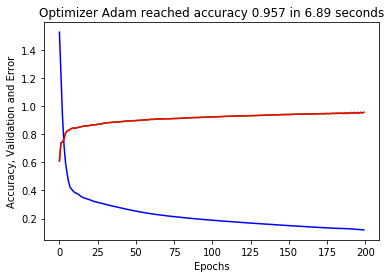

In [16]:
plotrange = epochs

plt.plot(range(plotrange), acc[0:plotrange], color='green')
plt.plot(range(plotrange), val[0:plotrange], color='blue')
plt.plot(range(plotrange), err[0:plotrange], color='r')
title = "Optimizer {} reached accuracy {:.3f} in {:.2f} seconds".format(optName, train_score, time01 - time00)
plt.xlabel('Epochs')
plt.ylabel('Accuracy, Validation and Error')
plt.title(title)
plt.show()